In [62]:
import os
from rich.pretty import pprint

import torch
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from visual_graph_datasets.util import dynamic_import
from visual_graph_datasets.processing.molecules import MoleculeProcessing
from visual_graph_datasets.visualization.base import draw_image
from visual_graph_datasets.visualization.base import create_frameless_figure
from visual_graph_datasets.visualization.molecules import visualize_molecular_graph_from_mol
from visual_graph_datasets.visualization.importances import plot_node_importances_background
from visual_graph_datasets.visualization.importances import plot_edge_importances_background
from graph_attention_student.torch.megan import Megan

plt.style.use('default')

In [114]:
PROCESSING_PATH = '/media/ssd/.visual_graph_datasets/datasets/aqsoldb/process.py'
PROCESSING_PATH = '/media/ssd/.visual_graph_datasets/datasets/tadf/process.py'
module = dynamic_import(PROCESSING_PATH)
processing: MoleculeProcessing = module.processing

In [178]:
#MODEL_PATH = '/media/ssd/Programming/graph_attention_student/graph_attention_student/experiments/results/vgd_torch__megan__aqsoldb/debug/model.ckpt'
MODEL_PATH = '/media/ssd/Programming/graph_attention_student/graph_attention_student/experiments/results/vgd_torch__megan__tadf/debug1/model.ckpt'
model = Megan.load(MODEL_PATH)

Processing SMILES - C1=CC=CC(N(C2=CC=CC=C2C2=CC3NC=NC3C=C2)C2=CC=CC=C2)=C1
created graph structure with 28 nodes and 64 edges


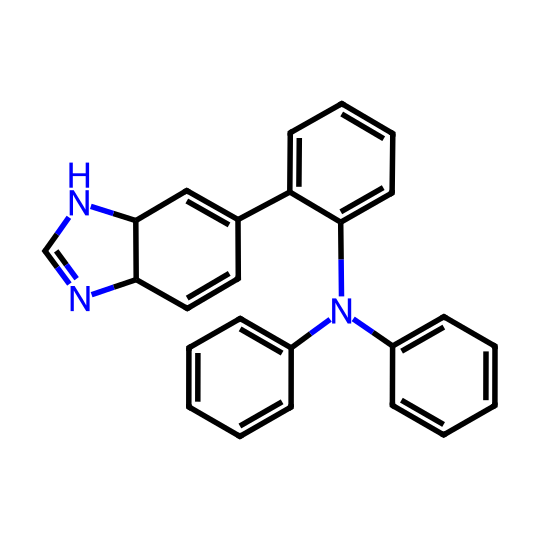

In [179]:
#SMILES: str = 'C1=CC=C2C3C=CC(C(N))=CC=3C=CC2=C1CCC'
#SMILES: str = 'C1=C(S(=O)(=O)O)C=C2C=CC=C([N+]([O-])=O)C2=C1'
SMILES: str = 'C1=CC=CC(N(C2=CC=CC=C2C2=CC3NC=NC3C=C2)C2=CC=CC=C2)=C1'
IMAGE_PATH: str = '/tmp/molecule.png'

WIDTH: int = 500
HEIGHT: int = 500
LINE_WIDTH: float = 11.0

# --- creating graph structure ---
graph = processing.process(SMILES)
print(f'Processing SMILES - {SMILES}')
print(f'created graph structure with {len(graph["node_indices"])} nodes and {len(graph["edge_indices"])} edges')

# --- creating visualization ---
mol = Chem.MolFromSmiles(SMILES)
        
fig, ax = create_frameless_figure(width=WIDTH, height=HEIGHT)
node_positions, svg_string = visualize_molecular_graph_from_mol(
    ax=ax,
    mol=mol,
    image_width=WIDTH,
    image_height=HEIGHT,
    line_width=LINE_WIDTH,
)

# The "node_positions" which are returned by the above function are values within the axes object
# coordinate system. Using the following piece of code we transform these into the actual pixel
# coordinates of the figure image.
node_positions = [[int(v) for v in ax.transData.transform((x, y))]
                    for x, y in node_positions]
node_positions = np.array(node_positions)

fig.savefig(IMAGE_PATH)

In [180]:
# --- model forward pass ---

info: dict = model.forward_graphs([graph])[0]
print('Model output keys:')
pprint(info.keys())

num_channels = info['node_importance'].shape[1]
print('Number of channels:', num_channels)

print('Prediction', info['graph_output'])

Model output keys:


dict_keys(['graph_output', 'graph_embedding', 'node_embedding', 'node_importance', 'node_importance_norm', 'edge_importance', 'edge_importance_norm', 'graph_variance'])

Number of channels: 2
Prediction [0.9888862]


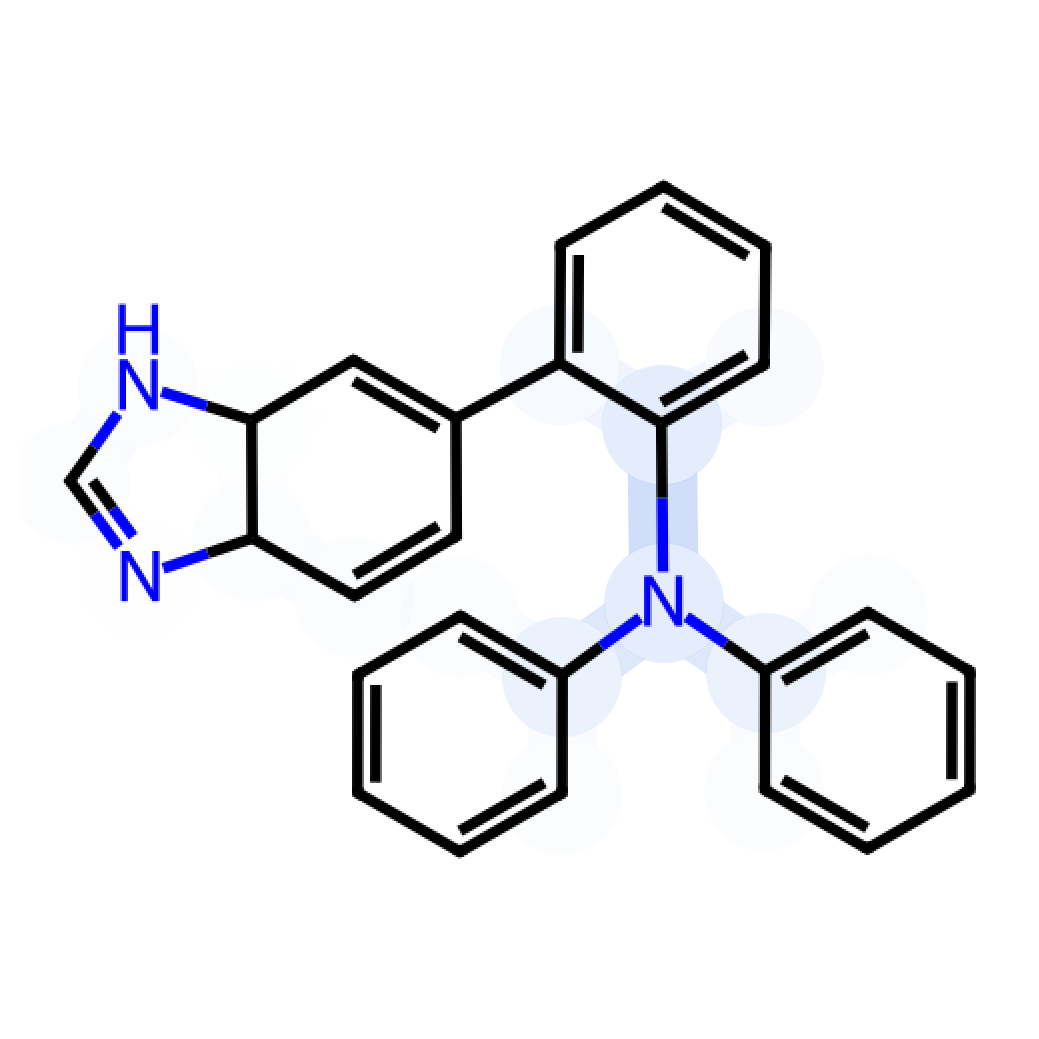

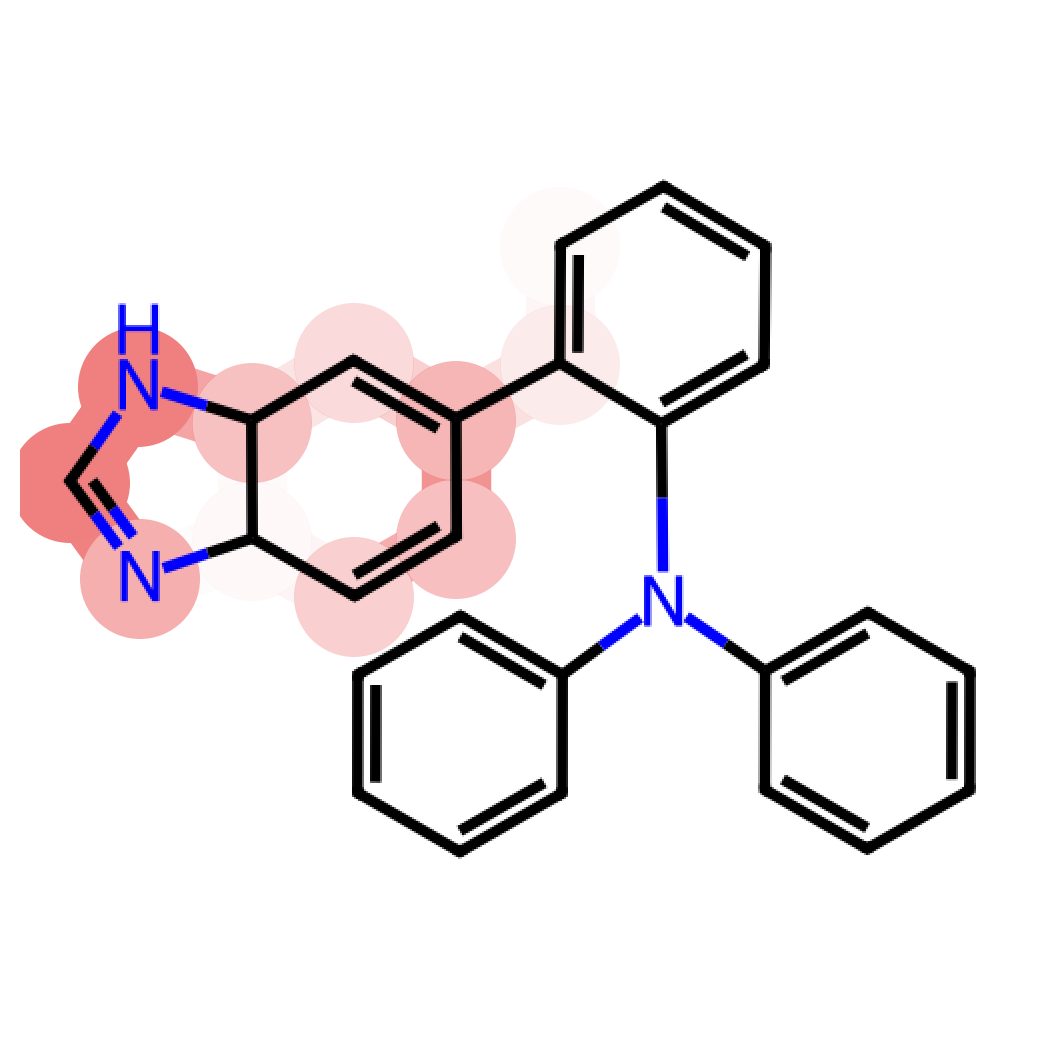

In [181]:
# --- visualizing explanations ---

node_importances = info['node_importance']
edge_importances = info['edge_importance']

for c in range(num_channels):
    
    fig, ax = create_frameless_figure(width=1000, height=1000)
    
    draw_image(ax=ax, image_path=IMAGE_PATH)
    
    color = 'lightgreen'
    if c == 0:
        color = 'cornflowerblue'
    elif c == 1:
        color = 'lightcoral'
    # if c == 0:
    #     color = 'sandybrown'
    # elif c == 1:
    #     color = 'violet'
    
    # node_importances[:, c] = node_importances[:, c] / np.max(node_importances[:, c])
    # edge_importances[:, c] = edge_importances[:, c] / np.max(edge_importances[:, c])

    node_importances = node_importances / np.max(np.abs(node_importances))
    edge_importances = edge_importances / np.max(np.abs(edge_importances))

    plot_node_importances_background(
        ax=ax,
        g=graph,
        node_positions=node_positions,
        node_importances=node_importances[:, c],
        radius=30,
        vmin=np.min(np.abs(node_importances)),
        vmax=np.max(np.abs(node_importances)),
        color=color
    )
    
    plot_edge_importances_background(
        ax=ax,
        g=graph,
        thickness=25,
        node_positions=node_positions,
        edge_importances=edge_importances[:, c],
        vmin=np.min(np.abs(edge_importances)),
        vmax=np.max(np.abs(edge_importances)),
        color=color,
    )
    
    plt.show()